In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

# Google Drive 上のファイルパス
file_path = '/content/drive/MyDrive/研究/データ/Nikkei225_統合.csv'

# CSV ファイルを読み込む
data = pd.read_csv('/content/drive/MyDrive/研究/データ/Nikkei225_統合.csv', encoding='shift_jis')


# データの先頭を確認
print(data.head())


       Date  収益率(Nikkei225)
0  1985/1/1          0.0390
1  1985/2/1          0.0274
2  1985/3/1          0.0217
3  1985/4/1         -0.0130
4  1985/5/1          0.0293


In [ ]:
# 収益率列を確認
returns = data['収益率(Nikkei225)']  # 必要に応じて列名を変更
print(returns.head())


0    0.0390
1    0.0274
2    0.0217
3   -0.0130
4    0.0293
Name: 収益率(Nikkei225), dtype: float64


In [ ]:
# 必要な列を収益率として抽出
returns = data['収益率(Nikkei225)'].dropna()  # 列名が異なる場合は調整
print(returns.head())

# 時系列データとしての基本統計量を確認
print(returns.describe())


0    0.0390
1    0.0274
2    0.0217
3   -0.0130
4    0.0293
Name: 収益率(Nikkei225), dtype: float64
count    480.000000
mean       0.004235
std        0.057492
min       -0.238300
25%       -0.028350
50%        0.007750
75%        0.041150
max        0.200600
Name: 収益率(Nikkei225), dtype: float64


期待収益率: 0.0042
標準偏差: 0.0575


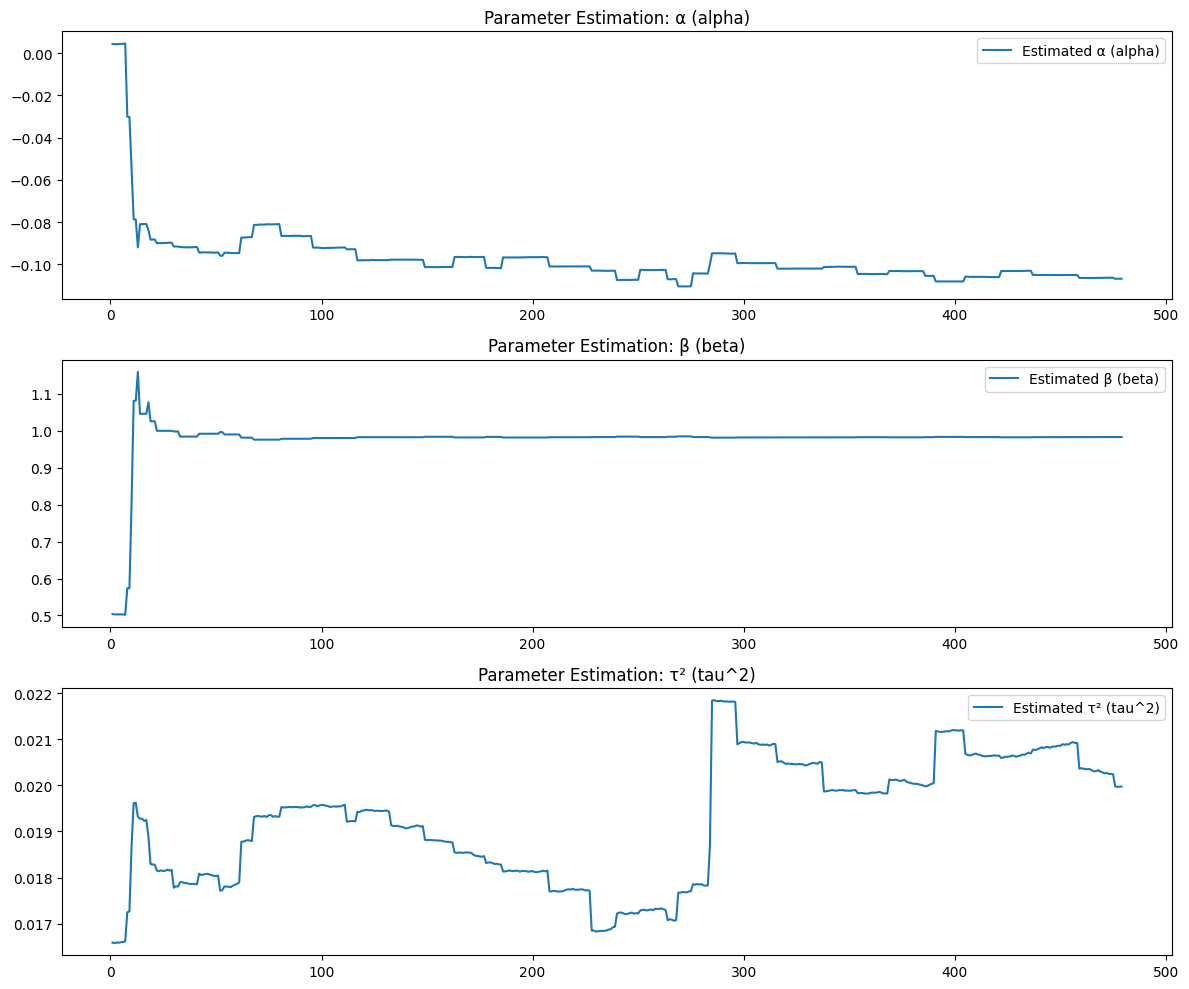

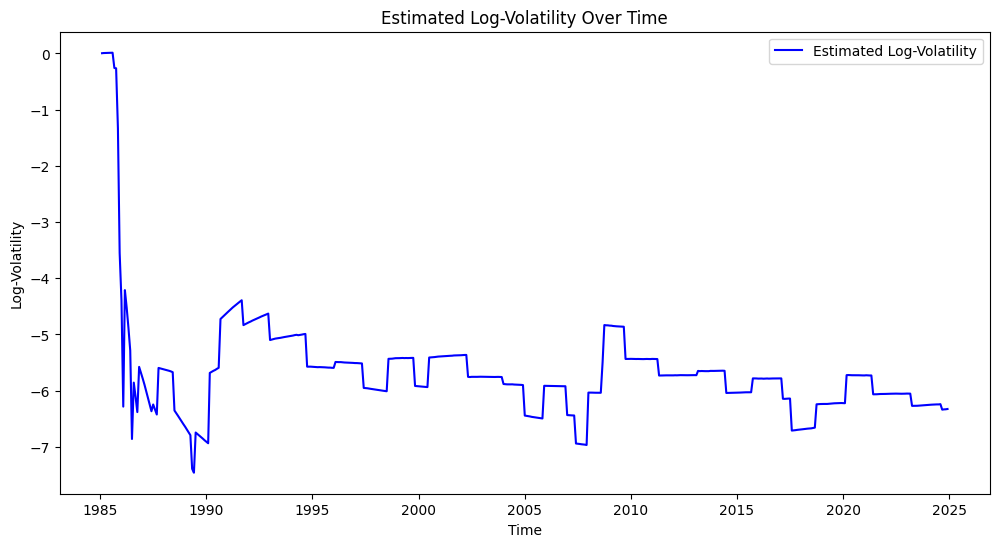

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# --- データ読み込み ---
file_path = "/content/drive/My Drive/研究/データ/Nikkei225_統合.csv"
data = pd.read_csv(file_path, encoding="shift_jis")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# --- 月次収益率の取得 ---
monthly_returns = data['収益率(Nikkei225)'].dropna()

# --- 基本統計量 ---
mean_return = monthly_returns.mean()
std_return = monthly_returns.std()

print(f"期待収益率: {mean_return:.4f}")
print(f"標準偏差: {std_return:.4f}")

# --- 事前分布の設定（正規分布を仮定） ---
n_particles = 10000
alpha_range = (mean_return - 2 * std_return, mean_return + 2 * std_return)
beta_range = (0, 1)
tau2_range = (0.1 * std_return**2, 10 * std_return**2)

initial_alpha = np.random.uniform(*alpha_range, n_particles)
initial_beta = np.random.uniform(*beta_range, n_particles)
initial_tau2 = np.random.uniform(*tau2_range, n_particles)

particles = np.stack([initial_alpha, initial_beta, initial_tau2], axis=1)

# --- Liu-Westフィルター ---
def liu_west_filter(data, particles, a=0.98):
    n_particles, d = particles.shape
    h = np.sqrt(1 - a**2)
    log_weights = np.full(n_particles, -np.log(n_particles))
    x_t_particles = np.zeros(n_particles)
    parameter_estimates = []
    estimated_x = []
    ESS = []

    for t in range(1, len(data)):
        y_t = data.iloc[t]

        # 縮小ルールによる粒子の予測
        mean_particles = np.mean(particles, axis=0)
        variance_particles = np.var(particles, axis=0)
        particles = a * particles + (1 - a) * mean_particles
        particles += np.random.normal(0, h * np.sqrt(variance_particles), particles.shape)

        # 状態方程式
        alpha, beta, tau2 = particles[:, 0], particles[:, 1], np.abs(particles[:, 2])
        x_t_particles = alpha + beta * x_t_particles + np.random.normal(0, np.sqrt(tau2), n_particles)

        # 観測方程式の尤度計算
        scale = np.exp(x_t_particles)
        log_likelihoods = norm.logpdf(y_t, loc=mean_return, scale=np.sqrt(scale))
        log_weights += log_likelihoods
        weights = np.exp(log_weights - np.max(log_weights))
        weights /= np.sum(weights)

        # ESS計算とリサンプリング
        ESS.append(1.0 / np.sum(weights**2))
        if ESS[-1] < n_particles / 2:
            indices = np.random.choice(range(n_particles), size=n_particles, p=weights)
            particles = particles[indices]
            x_t_particles = x_t_particles[indices]
            log_weights = -np.log(n_particles)

        # 推定値を記録
        parameter_estimates.append(np.mean(particles, axis=0))
        estimated_x.append(np.mean(x_t_particles))

    return parameter_estimates, estimated_x, ESS

# --- 推定実行 ---
parameter_estimates, estimated_x, ESS = liu_west_filter(monthly_returns, particles)

# --- 推定結果のプロット ---
parameter_estimates = np.array(parameter_estimates)
time_steps = range(1, len(parameter_estimates) + 1)

plt.figure(figsize=(12, 10))
labels = ["α (alpha)", "β (beta)", "τ² (tau^2)"]
for i, label in enumerate(labels):
    plt.subplot(3, 1, i + 1)
    plt.plot(time_steps, parameter_estimates[:, i], label=f"Estimated {label}")
    plt.legend()
    plt.title(f"Parameter Estimation: {label}")

plt.tight_layout()
plt.show()

# --- ボラティリティの推移 ---
plt.figure(figsize=(12, 6))
plt.plot(monthly_returns.index[1:], estimated_x, label="Estimated Log-Volatility", color="blue")
plt.title("Estimated Log-Volatility Over Time")
plt.xlabel("Time")
plt.ylabel("Log-Volatility")
plt.legend()
plt.show()


固定パラメータ: α = -0.1057, β = 0.9826, τ² = 0.0206


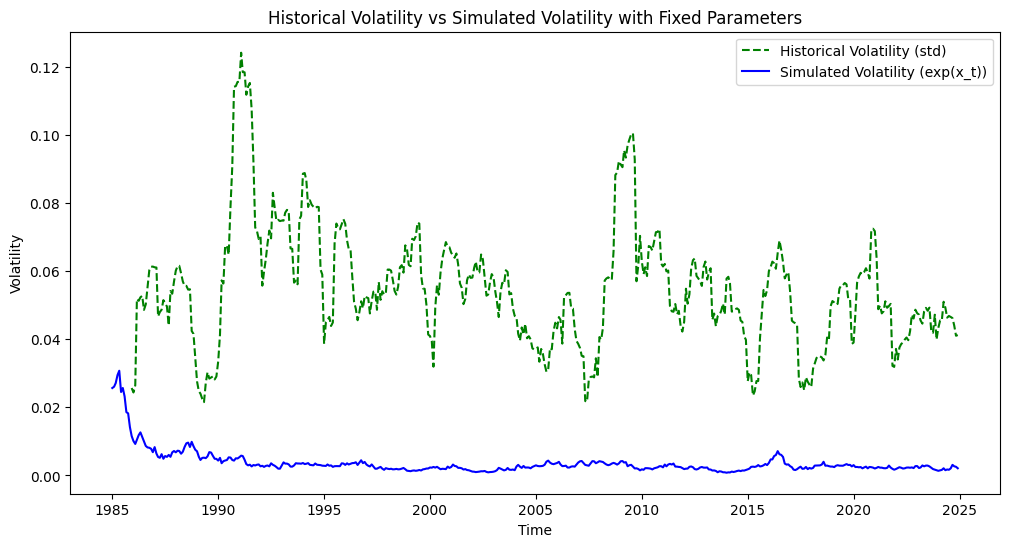

In [ ]:
# --- 推定パラメータの平均値を計算 ---
stable_estimates = parameter_estimates[int(0.8 * len(parameter_estimates)):]  # 最終20%を使用
mean_alpha = np.mean(stable_estimates[:, 0])
mean_beta = np.mean(stable_estimates[:, 1])
mean_tau2 = np.mean(stable_estimates[:, 2])

print(f"固定パラメータ: α = {mean_alpha:.4f}, β = {mean_beta:.4f}, τ² = {mean_tau2:.4f}")
# --- 固定パラメータでのボラティリティ推定 ---
n_steps = len(monthly_returns)
x_t_simulated = np.zeros(n_steps)

# 状態変数の初期値を設定
# 初期値をヒストリカルボラティリティの最初の値に基づいて設定
x_t_simulated[0] = np.log(historical_volatility.iloc[0])  # 例: ヒストリカルボラティリティから設定

# 状態方程式に基づくシミュレーション
for t in range(1, n_steps):
    x_t_simulated[t] = mean_alpha + mean_beta * x_t_simulated[t-1] + np.random.normal(0, np.sqrt(mean_tau2))

estimated_volatility = np.exp(x_t_simulated)

# --- ヒストリカルボラティリティ vs 推定ボラティリティ ---
plt.figure(figsize=(12, 6))

# 実測のヒストリカルボラティリティ
plt.plot(historical_volatility.index, historical_volatility, label="Historical Volatility (std)", color="green", linestyle="--")

# 固定パラメータによる推定ボラティリティ
plt.plot(monthly_returns.index, estimated_volatility, label="Simulated Volatility (exp(x_t))", color="blue")

# ラベルとタイトル
plt.title("Historical Volatility vs Simulated Volatility with Fixed Parameters")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.show()


期待収益率: 0.0042
標準偏差: 0.0575


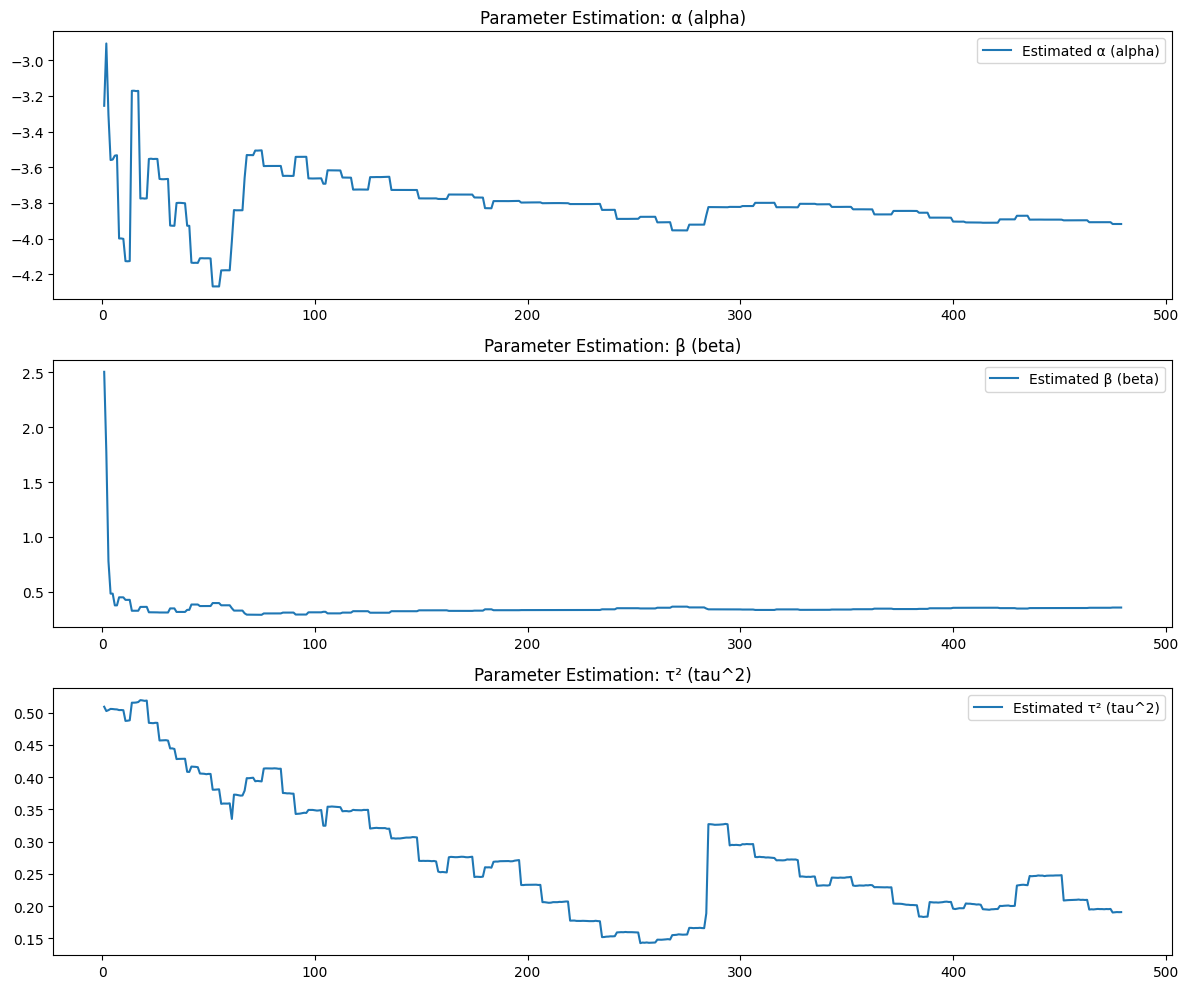

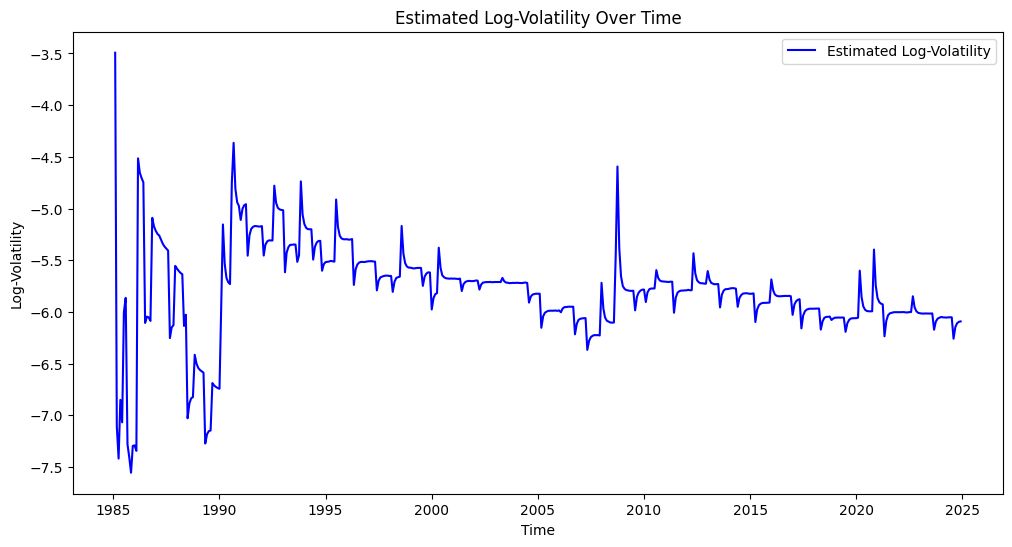

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# --- データ読み込み ---
file_path = "/content/drive/My Drive/研究/データ/Nikkei225_統合.csv"
data = pd.read_csv(file_path, encoding="shift_jis")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# --- 月次収益率の取得 ---
monthly_returns = data['収益率(Nikkei225)'].dropna()

# --- 基本統計量 ---
mean_return = monthly_returns.mean()
std_return = monthly_returns.std()

print(f"期待収益率: {mean_return:.4f}")
print(f"標準偏差: {std_return:.4f}")

# --- 事前分布の設定（正規分布を仮定） ---
n_particles = 100000
initial_alpha = np.random.uniform(-5, 5,size=n_particles)
initial_beta = np.random.uniform(0.001, 5,n_particles)
initial_tau2 = np.random.uniform(0.0001, 1,n_particles)

particles = np.stack([initial_alpha, initial_beta, initial_tau2], axis=1)

# --- Liu-Westフィルター ---
def liu_west_filter(data, particles, a=0.9):
    n_particles, d = particles.shape
    h = np.sqrt(1 - a**2)
    log_weights = np.full(n_particles, -np.log(n_particles))
    x_t_particles = np.zeros(n_particles)
    parameter_estimates = []
    estimated_x = []
    ESS = []

    for t in range(1, len(data)):
        y_t = data.iloc[t]

        # 縮小ルールによる粒子の予測
        mean_particles = np.mean(particles, axis=0)
        variance_particles = np.var(particles, axis=0)
        particles = a * particles + (1 - a) * mean_particles
        particles += np.random.normal(0, h * np.sqrt(variance_particles), particles.shape)

        # 状態方程式
        alpha, beta, tau2 = particles[:, 0], particles[:, 1], np.abs(particles[:, 2])
        x_t_particles = alpha + beta * x_t_particles + np.random.normal(0, np.sqrt(tau2), n_particles)

        # 観測方程式の尤度計算
        scale = np.exp(x_t_particles)
        log_likelihoods = norm.logpdf(y_t, loc=mean_return, scale=np.sqrt(scale))
        log_weights += log_likelihoods
        weights = np.exp(log_weights - np.max(log_weights))
        weights /= np.sum(weights)

        # ESS計算とリサンプリング
        ESS.append(1.0 / np.sum(weights**2))
        if ESS[-1] < n_particles / 2:
            indices = np.random.choice(range(n_particles), size=n_particles, p=weights)
            particles = particles[indices]
            x_t_particles = x_t_particles[indices]
            log_weights = -np.log(n_particles)

        # 推定値を記録
        parameter_estimates.append(np.mean(particles, axis=0))
        estimated_x.append(np.mean(x_t_particles))

    return parameter_estimates, estimated_x, ESS

# --- 推定実行 ---
parameter_estimates, estimated_x, ESS = liu_west_filter(monthly_returns, particles)

# --- 推定結果のプロット ---
parameter_estimates = np.array(parameter_estimates)
time_steps = range(1, len(parameter_estimates) + 1)

plt.figure(figsize=(12, 10))
labels = ["α (alpha)", "β (beta)", "τ² (tau^2)"]
for i, label in enumerate(labels):
    plt.subplot(3, 1, i + 1)
    plt.plot(time_steps, parameter_estimates[:, i], label=f"Estimated {label}")
    plt.legend()
    plt.title(f"Parameter Estimation: {label}")

plt.tight_layout()
plt.show()

# --- ボラティリティの推移 ---
plt.figure(figsize=(12, 6))
plt.plot(monthly_returns.index[1:], estimated_x, label="Estimated Log-Volatility", color="blue")
plt.title("Estimated Log-Volatility Over Time")
plt.xlabel("Time")
plt.ylabel("Log-Volatility")
plt.legend()
plt.show()


固定パラメータ: α = -3.8686, β = 0.3466, τ² = 0.2188


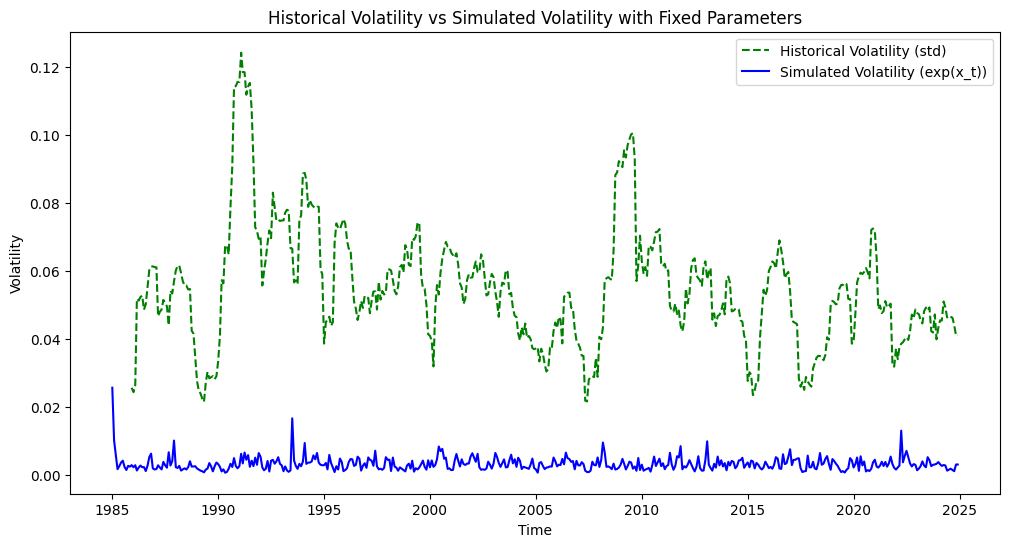

In [ ]:
# --- 推定パラメータの平均値を計算 ---
stable_estimates = parameter_estimates[int(0.5 * len(parameter_estimates)):]  # 最終20%を使用
mean_alpha = np.mean(stable_estimates[:, 0])
mean_beta = np.mean(stable_estimates[:, 1])
mean_tau2 = np.mean(stable_estimates[:, 2])

print(f"固定パラメータ: α = {mean_alpha:.4f}, β = {mean_beta:.4f}, τ² = {mean_tau2:.4f}")
# --- 固定パラメータでのボラティリティ推定 ---
n_steps = len(monthly_returns)
x_t_simulated = np.zeros(n_steps)

# 状態変数の初期値を設定
# 初期値をヒストリカルボラティリティの最初の値に基づいて設定
x_t_simulated[0] = np.log(historical_volatility.iloc[0])  # 例: ヒストリカルボラティリティから設定

# 状態方程式に基づくシミュレーション
for t in range(1, n_steps):
    x_t_simulated[t] = mean_alpha + mean_beta * x_t_simulated[t-1] + np.random.normal(0, np.sqrt(mean_tau2))

estimated_volatility = np.exp(x_t_simulated)

# --- ヒストリカルボラティリティ vs 推定ボラティリティ ---
plt.figure(figsize=(12, 6))

# 実測のヒストリカルボラティリティ
plt.plot(historical_volatility.index, historical_volatility, label="Historical Volatility (std)", color="green", linestyle="--")

# 固定パラメータによる推定ボラティリティ
plt.plot(monthly_returns.index, estimated_volatility, label="Simulated Volatility (exp(x_t))", color="blue")

# ラベルとタイトル
plt.title("Historical Volatility vs Simulated Volatility with Fixed Parameters")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.show()


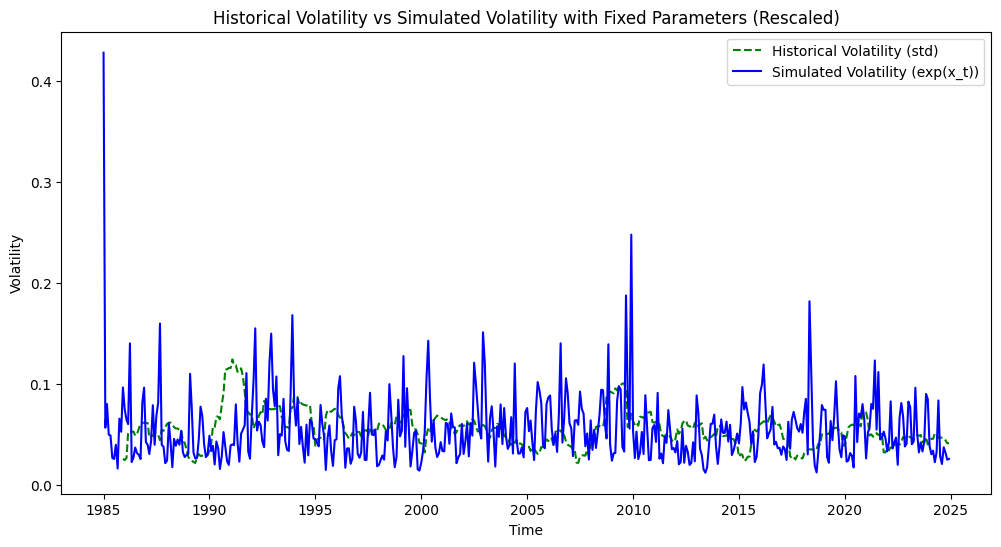

In [ ]:
# --- 固定パラメータでのボラティリティ推定 ---
n_steps = len(monthly_returns)
x_t_simulated = np.zeros(n_steps)

# 初期値をヒストリカルボラティリティに基づいて設定
x_t_simulated[0] = np.log(historical_volatility.iloc[0] + 1e-6)

# 状態方程式に基づくシミュレーション
for t in range(1, n_steps):
    x_t_simulated[t] = mean_alpha + mean_beta * x_t_simulated[t-1] + np.random.normal(0, np.sqrt(mean_tau2))

estimated_volatility = np.exp(x_t_simulated)

# スケール調整
scale_factor = np.mean(historical_volatility) / np.mean(estimated_volatility)
estimated_volatility *= scale_factor

# --- ヒストリカルボラティリティ vs 推定ボラティリティ ---
plt.figure(figsize=(12, 6))

# 実測のヒストリカルボラティリティ
plt.plot(historical_volatility.index, historical_volatility, label="Historical Volatility (std)", color="green", linestyle="--")

# 固定パラメータによる推定ボラティリティ
plt.plot(monthly_returns.index, estimated_volatility, label="Simulated Volatility (exp(x_t))", color="blue")

# ラベルとタイトル
plt.title("Historical Volatility vs Simulated Volatility with Fixed Parameters (Rescaled)")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.show()


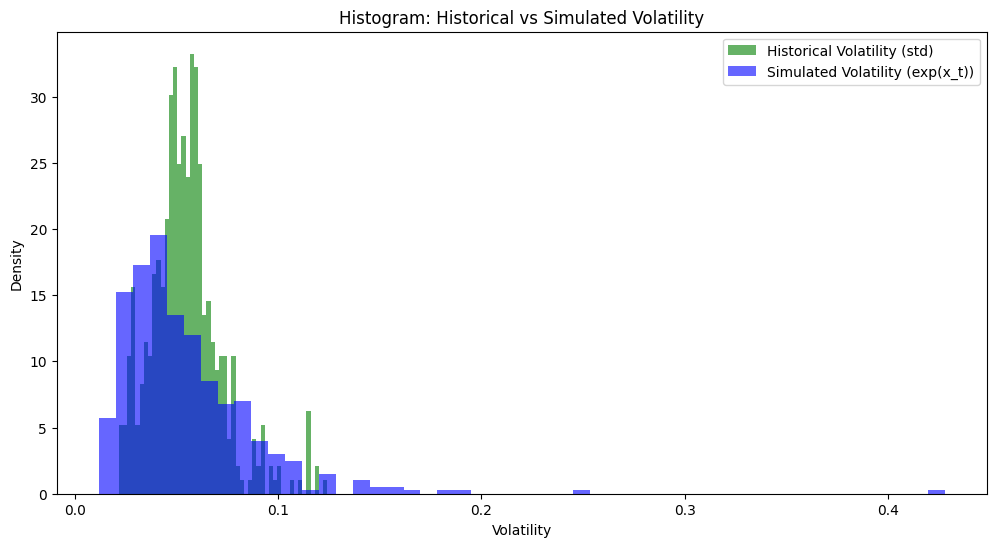

In [ ]:
plt.figure(figsize=(12, 6))

# ヒストリカルボラティリティの分布
plt.hist(historical_volatility, bins=50, alpha=0.6, label="Historical Volatility (std)", density=True, color="green")

# 推定ボラティリティの分布
plt.hist(estimated_volatility, bins=50, alpha=0.6, label="Simulated Volatility (exp(x_t))", density=True, color="blue")

# ラベルとタイトル
plt.title("Histogram: Historical vs Simulated Volatility")
plt.xlabel("Volatility")
plt.ylabel("Density")
plt.legend()
plt.show()


In [2]:
# CSVファイルからデータを読み込む
file_path = '/content/drive/MyDrive/研究/データ/Nikkei225_統合.csv'  # パスを指定
data = pd.read_csv(file_path, encoding='shift_jis', parse_dates=['Date'], index_col='Date')

# 月次の収益率を取得
returns = data['収益率(Nikkei225)'].dropna()

# 必要に応じてnumpy配列へ変換
y_t = returns.values


NameError: name 'pd' is not defined

In [ ]:
# SVモデル: シミュレーション用
def sv_model_simulation(alpha, beta, tau2, x_init, n_steps):
    x_t = np.zeros(n_steps)
    y_t_simulated = np.zeros(n_steps)
    x_t[0] = x_init

    for t in range(1, n_steps):
        x_t[t] = alpha + beta * x_t[t - 1] + np.random.normal(0, np.sqrt(tau2))
        scale = np.exp(x_t[t])
        y_t_simulated[t] = np.random.normal(0, np.sqrt(scale))

    return y_t_simulated, x_t


In [ ]:
def liu_west_filter(data, particles, a=0.95):
    n_particles, d = particles.shape
    h = np.sqrt(1 - a**2)
    log_weights = np.full(n_particles, -np.log(n_particles))
    parameter_estimates = []

    for t, y_t in enumerate(data):
        # 粒子の更新
        mean_particles = np.mean(particles, axis=0)
        variance_particles = np.var(particles, axis=0)
        particles = a * particles + (1 - a) * mean_particles
        particles += np.random.normal(0, h * np.sqrt(variance_particles), particles.shape)

        # 尤度計算
        alpha, beta, tau2 = particles[:, 0], particles[:, 1], np.abs(particles[:, 2])
        scale = np.exp(alpha + beta * y_t)
        log_likelihoods = norm.logpdf(y_t, loc=0, scale=np.sqrt(scale))
        log_weights += log_likelihoods

        # 正規化された重み
        weights = np.exp(log_weights - np.max(log_weights))
        weights /= np.sum(weights)

        # リサンプリング
        ess = 1.0 / np.sum(weights**2)
        if ess < n_particles / 2:
            indices = np.random.choice(range(n_particles), size=n_particles, p=weights)
            particles = particles[indices]
            log_weights = -np.log(n_particles)

        # 推定値を記録
        parameter_estimates.append(np.mean(particles, axis=0))

    return parameter_estimates


In [ ]:
# パラメータ推定
n_particles = 100000
n_steps = len(y_t)

# 初期粒子の設定
initial_alpha = np.random.uniform(-10, 10, n_particles)
initial_beta = np.random.uniform(-10,10, n_particles)
initial_tau2 = np.abs(np.random.normal(0.001, 1, n_particles))
particles = np.stack([initial_alpha, initial_beta, initial_tau2], axis=1)

# 推定
parameter_estimates = liu_west_filter(y_t, particles)

# 推定されたパラメータの平均 (バーンイン後)
burn_in = int(0.1 * len(parameter_estimates))
alpha_mean = np.mean([est[0] for est in parameter_estimates[burn_in:]])
beta_mean = np.mean([est[1] for est in parameter_estimates[burn_in:]])
tau2_mean = np.mean([est[2] for est in parameter_estimates[burn_in:]])

# シミュレーション
simulated_y, _ = sv_model_simulation(alpha_mean, beta_mean, tau2_mean, np.log(y_t[0]), n_steps)


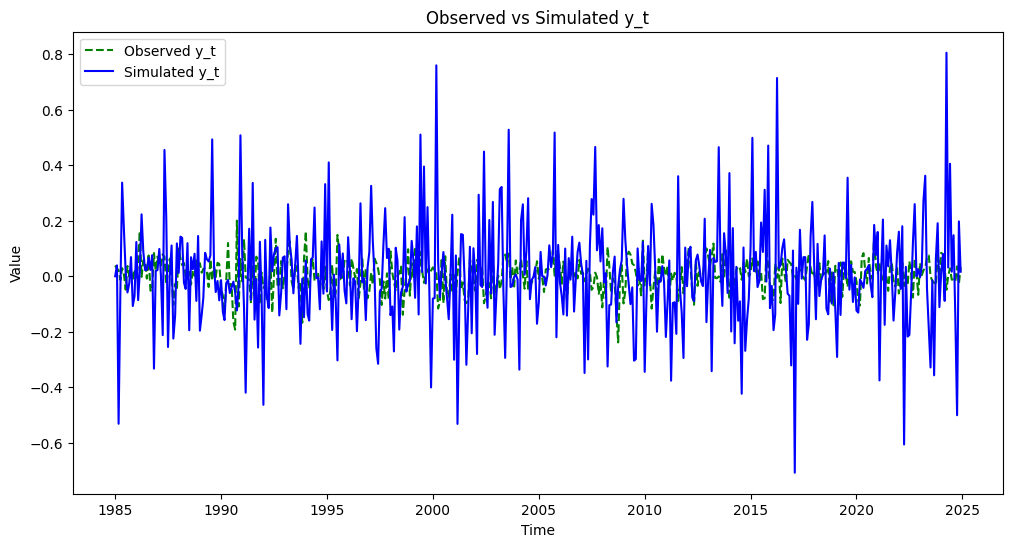

In [ ]:
# 実データ vs シミュレーション結果のプロット
plt.figure(figsize=(12, 6))
plt.plot(returns.index, returns, label="Observed y_t", linestyle="--", color="green")
plt.plot(returns.index, simulated_y, label="Simulated y_t", color="blue")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Observed vs Simulated y_t")
plt.legend()
plt.show()


In [1]:
# --- 推定プロセスの可視化 --- #

# パラメータ推移のプロット
parameter_estimates = np.array(parameter_estimates)
time_steps = range(len(parameter_estimates))

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(time_steps, parameter_estimates[:, 0], label="α (alpha)", color="blue")
plt.axhline(alpha_mean, color="green", linestyle="--", label="Mean α (after burn-in)")
plt.title("Parameter Trajectory: α (alpha)")
plt.xlabel("Step")
plt.ylabel("Value")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time_steps, parameter_estimates[:, 1], label="β (beta)", color="blue")
plt.axhline(beta_mean, color="red", linestyle="--", label="Mean β (after burn-in)")
plt.title("Parameter Trajectory: β (beta)")
plt.xlabel("Step")
plt.ylabel("Value")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time_steps, parameter_estimates[:, 2], label="τ² (tau^2)", color="blue")
plt.axhline(tau2_mean, color="red", linestyle="--", label="Mean τ² (after burn-in)")
plt.title("Parameter Trajectory: τ² (tau^2)")
plt.xlabel("Step")
plt.ylabel("Value")
plt.legend()

plt.tight_layout()
plt.show()

# --- 推定パラメータの分布 --- #
burned_in_estimates = parameter_estimates[burn_in:]  # バーンイン後の推定値を使用

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.hist(burned_in_estimates[:, 0], bins=50, color="blue", alpha=0.7, label="α (alpha)")
plt.axvline(alpha_mean, color="red", linestyle="--", label="Mean α")
plt.title("Posterior Distribution: α (alpha)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(burned_in_estimates[:, 1], bins=50, color="blue", alpha=0.7, label="β (beta)")
plt.axvline(beta_mean, color="red", linestyle="--", label="Mean β")
plt.title("Posterior Distribution: β (beta)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(burned_in_estimates[:, 2], bins=50, color="blue", alpha=0.7, label="τ² (tau^2)")
plt.axvline(tau2_mean, color="red", linestyle="--", label="Mean τ²")
plt.title("Posterior Distribution: τ² (tau^2)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()


NameError: name 'np' is not defined

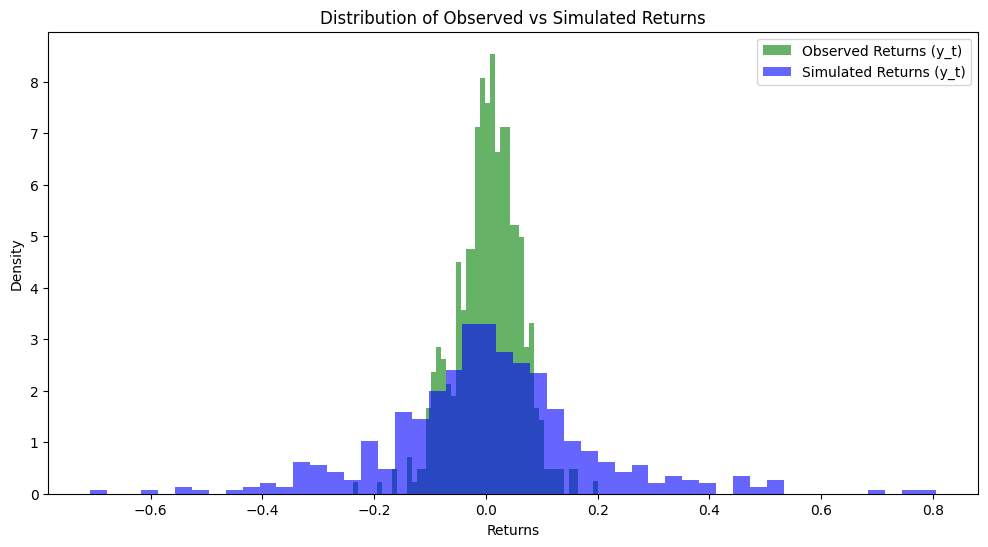

In [ ]:
# --- 実データとシミュレーションデータの分布比較 --- #
plt.figure(figsize=(12, 6))

# 実データのヒストグラム
plt.hist(y_t, bins=50, density=True, alpha=0.6, label="Observed Returns (y_t)", color="green")

# シミュレーションデータのヒストグラム
plt.hist(simulated_y, bins=50, density=True, alpha=0.6, label="Simulated Returns (y_t)", color="blue")

# プロットの詳細設定
plt.title("Distribution of Observed vs Simulated Returns")
plt.xlabel("Returns")
plt.ylabel("Density")
plt.legend()
plt.show()


In [ ]:

# --- t分布のLiu-Westフィルター --- #
def liu_west_filter_t(data, particles, a=0.98):
    """
    Liu-Westフィルター: t分布の自由度を含むパラメータ推定
    :param data: 観測データ y_t
    :param particles: 初期粒子 (alpha, beta, tau2, eta)
    :param a: 縮小パラメータ
    :return: パラメータ推定値、推定状態変数、ESS
    """
    n_particles, d = particles.shape  # d=4 (alpha, beta, tau2, eta)
    h = np.sqrt(1 - a**2)
    log_weights = np.full(n_particles, -np.log(n_particles))
    x_t_particles = np.zeros(n_particles)
    parameter_estimates = []
    estimated_x = []
    ESS = []

    for t in range(1, len(data)):
        y_t = data[t]

        # 粒子更新 (縮小ルール)
        mean_particles = np.mean(particles, axis=0)
        variance_particles = np.var(particles, axis=0)
        particles = a * particles + (1 - a) * mean_particles
        particles += np.random.normal(0, h * np.sqrt(variance_particles), particles.shape)

        # 状態方程式
        alpha, beta, tau2, eta = particles[:, 0], particles[:, 1], np.abs(particles[:, 2]), np.abs(particles[:, 3])
        x_t_particles = alpha + beta * x_t_particles + np.random.normal(0, np.sqrt(tau2), n_particles)
        x_t_particles = np.clip(x_t_particles, -10, 10)

        # 観測方程式の尤度計算 (t分布)
        from scipy.stats import norm, t
        scale = np.exp(x_t_particles)
        log_likelihoods = t.logpdf(y_t, df=eta, loc=0, scale=np.sqrt(scale))
        log_weights += log_likelihoods
        log_weights = np.nan_to_num(log_weights, nan=-np.inf, posinf=-np.inf)
        weights = np.exp(log_weights - np.max(log_weights))
        weights /= np.sum(weights)

        # 有効サンプルサイズ (ESS)
        ess = 1.0 / np.sum(weights**2)
        ESS.append(ess)

        # リサンプリング
        if ess < n_particles / 2:
            indices = np.random.choice(range(n_particles), size=n_particles, p=weights)
            particles = particles[indices]
            x_t_particles = x_t_particles[indices]
            log_weights = -np.log(n_particles)

        # パラメータと状態変数の推定値を記録
        parameter_estimates.append(np.mean(particles, axis=0))
        estimated_x.append(np.mean(x_t_particles))

    return parameter_estimates, estimated_x, ESS


In [ ]:
# 初期粒子の設定
n_particles = 100000
initial_alpha = np.random.uniform(-10, 10, n_particles)
initial_beta = np.random.uniform(-10, 10, n_particles)
initial_tau2 = np.abs(np.random.normal(0.001, 1, n_particles))
initial_eta = np.random.uniform(2, 30, n_particles)  # 自由度の初期分布
particles = np.stack([initial_alpha, initial_beta, initial_tau2, initial_eta], axis=1)


In [ ]:
from scipy.stats import t

# Liu-Westフィルターを適用
parameter_estimates_t, estimated_x_t, ESS_t = liu_west_filter_t(y_t, particles)


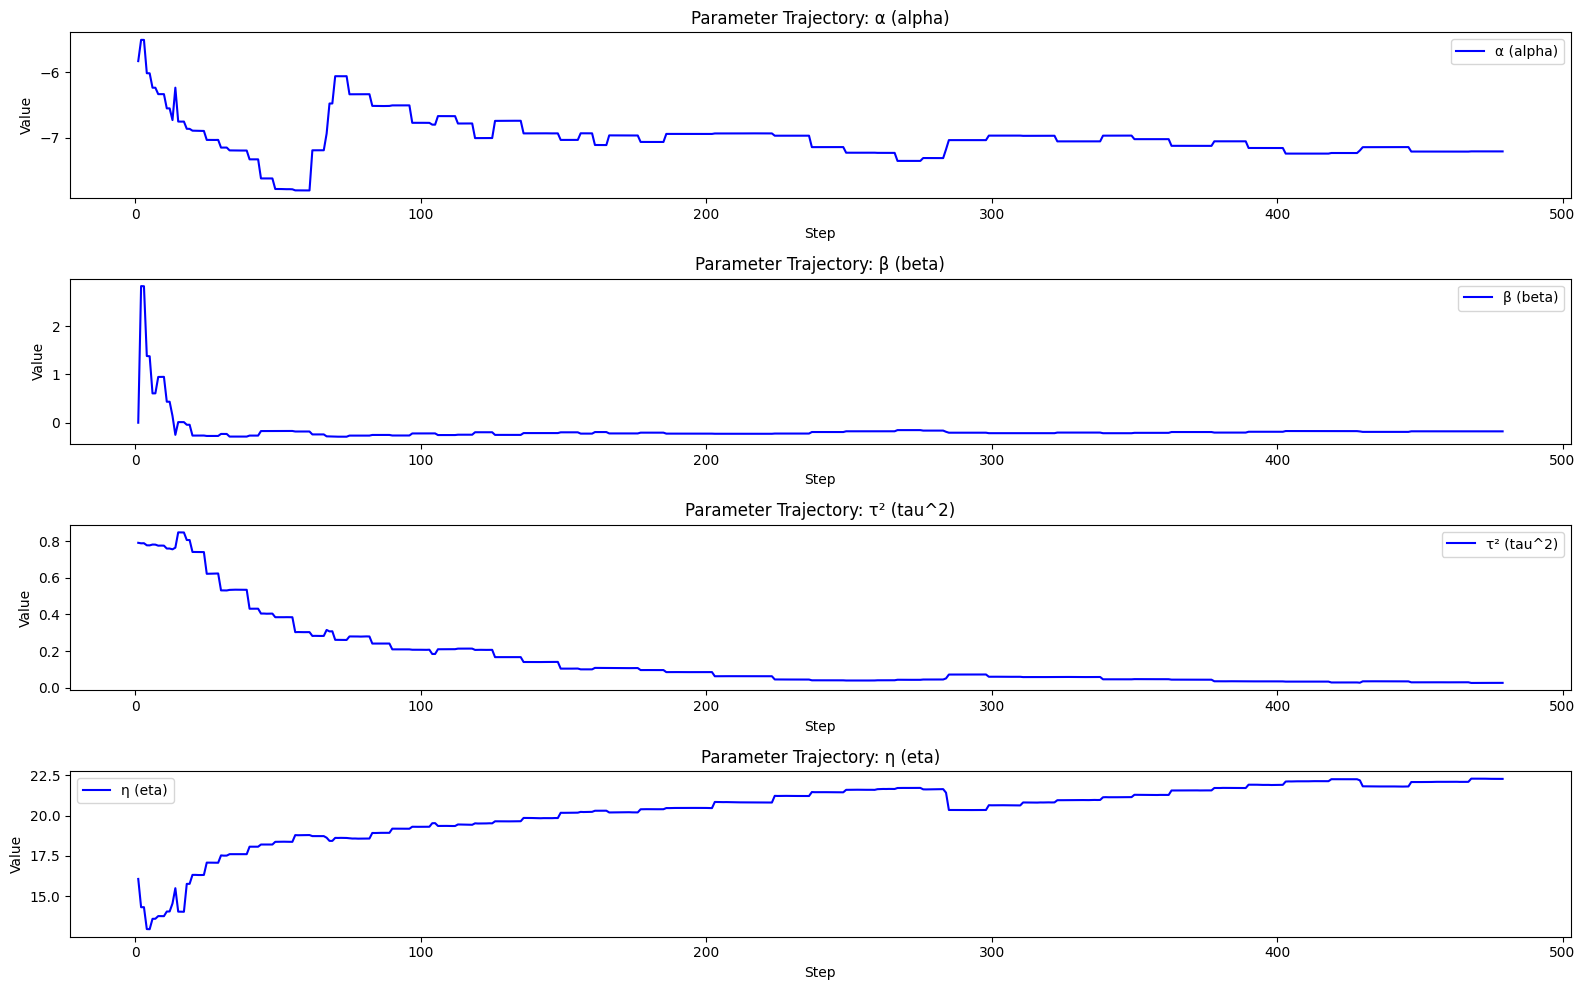

In [ ]:
# 推定結果のプロット
parameter_estimates_t = np.array(parameter_estimates_t)
time_steps = range(1, len(parameter_estimates_t) + 1)

plt.figure(figsize=(16, 10))
plt.subplot(4, 1, 1)
plt.plot(time_steps, parameter_estimates_t[:, 0], label="α (alpha)", color="blue")
plt.title("Parameter Trajectory: α (alpha)")
plt.xlabel("Step")
plt.ylabel("Value")
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(time_steps, parameter_estimates_t[:, 1], label="β (beta)", color="blue")
plt.title("Parameter Trajectory: β (beta)")
plt.xlabel("Step")
plt.ylabel("Value")
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(time_steps, parameter_estimates_t[:, 2], label="τ² (tau^2)", color="blue")
plt.title("Parameter Trajectory: τ² (tau^2)")
plt.xlabel("Step")
plt.ylabel("Value")
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(time_steps, parameter_estimates_t[:, 3], label="η (eta)", color="blue")
plt.title("Parameter Trajectory: η (eta)")
plt.xlabel("Step")
plt.ylabel("Value")
plt.legend()

plt.tight_layout()
plt.show()


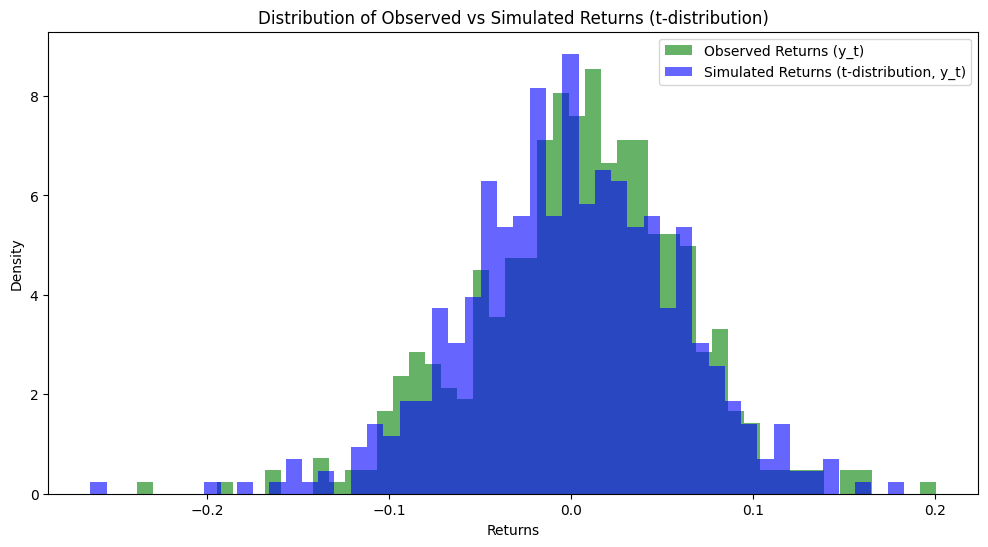

In [ ]:
# バーンイン後の平均値を使用
burn_in = int(0.1 * len(parameter_estimates_t))
alpha_mean, beta_mean, tau2_mean, eta_mean = np.mean(parameter_estimates_t[burn_in:], axis=0)

# 推定されたパラメータでシミュレーション
simulated_y_t, _ = sv_model_simulation(alpha_mean, beta_mean, tau2_mean, np.log(y_t[0]), len(y_t))

# 分布比較
plt.figure(figsize=(12, 6))
plt.hist(y_t, bins=50, density=True, alpha=0.6, label="Observed Returns (y_t)", color="green")
plt.hist(simulated_y_t, bins=50, density=True, alpha=0.6, label="Simulated Returns (t-distribution, y_t)", color="blue")
plt.title("Distribution of Observed vs Simulated Returns (t-distribution)")
plt.xlabel("Returns")
plt.ylabel("Density")
plt.legend()
plt.show()


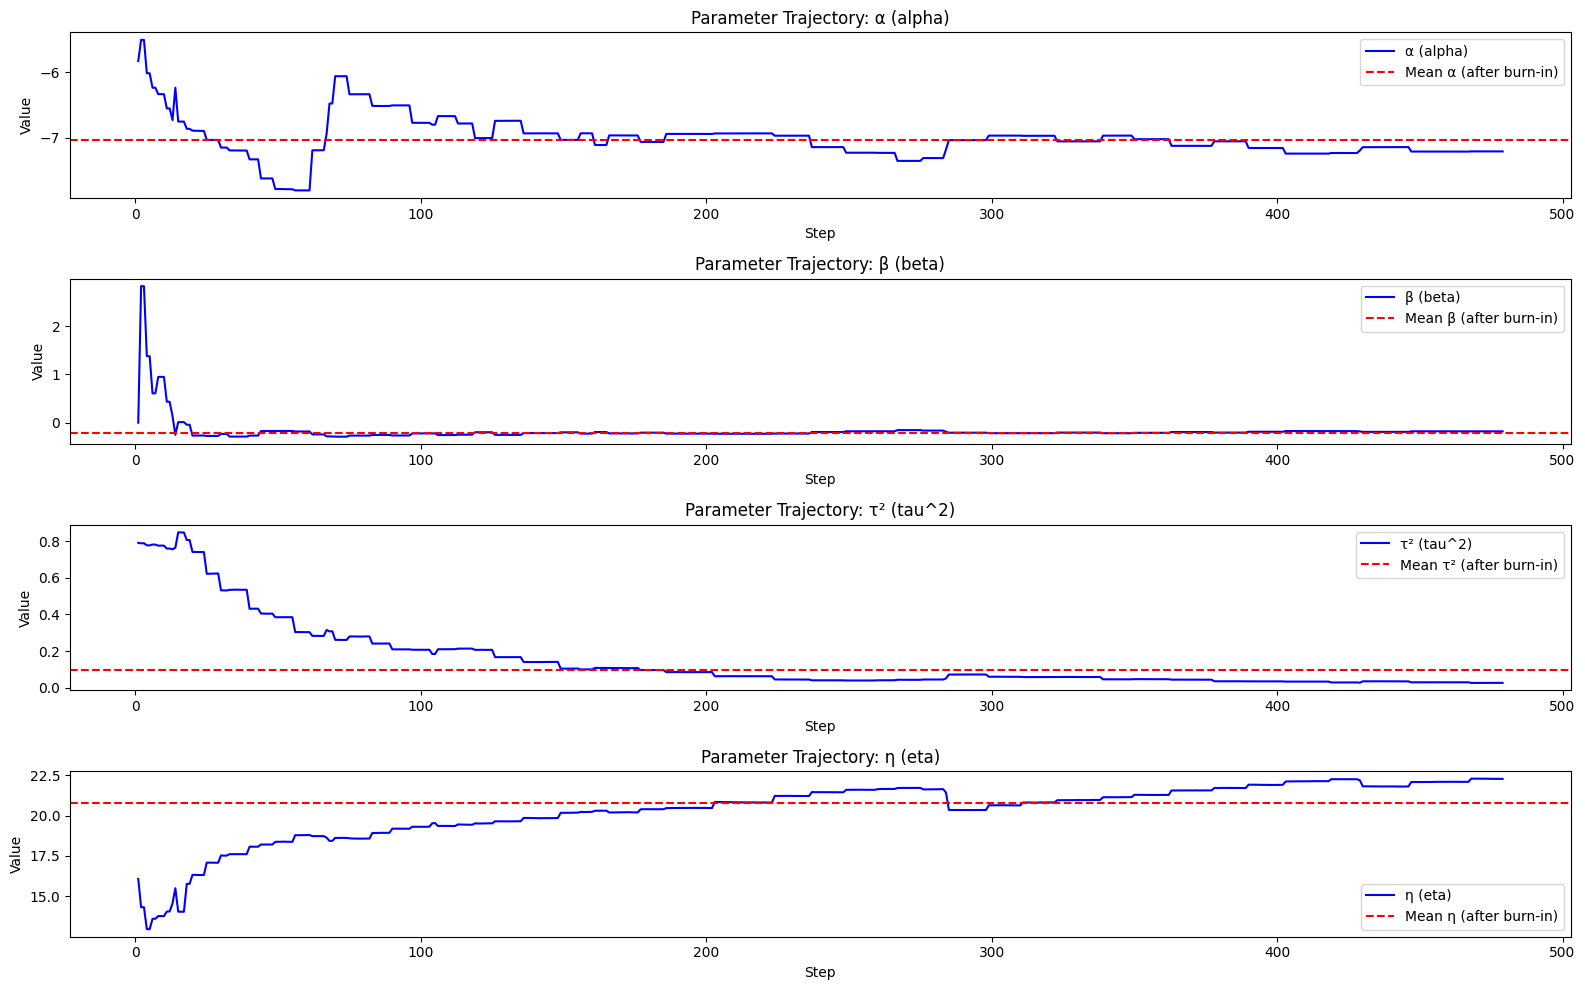

In [ ]:
# 推定結果のプロット
parameter_estimates_t = np.array(parameter_estimates_t)
time_steps = range(1, len(parameter_estimates_t) + 1)

# バーンイン後の平均値を計算
burn_in = int(0.1 * len(parameter_estimates_t))
alpha_mean_t, beta_mean_t, tau2_mean_t, eta_mean_t = np.mean(parameter_estimates_t[burn_in:], axis=0)

plt.figure(figsize=(16, 10))
plt.subplot(4, 1, 1)
plt.plot(time_steps, parameter_estimates_t[:, 0], label="α (alpha)", color="blue")
plt.axhline(alpha_mean_t, color="red", linestyle="--", label="Mean α (after burn-in)")
plt.title("Parameter Trajectory: α (alpha)")
plt.xlabel("Step")
plt.ylabel("Value")
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(time_steps, parameter_estimates_t[:, 1], label="β (beta)", color="blue")
plt.axhline(beta_mean_t, color="red", linestyle="--", label="Mean β (after burn-in)")
plt.title("Parameter Trajectory: β (beta)")
plt.xlabel("Step")
plt.ylabel("Value")
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(time_steps, parameter_estimates_t[:, 2], label="τ² (tau^2)", color="blue")
plt.axhline(tau2_mean_t, color="red", linestyle="--", label="Mean τ² (after burn-in)")
plt.title("Parameter Trajectory: τ² (tau^2)")
plt.xlabel("Step")
plt.ylabel("Value")
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(time_steps, parameter_estimates_t[:, 3], label="η (eta)", color="blue")
plt.axhline(eta_mean_t, color="red", linestyle="--", label="Mean η (after burn-in)")
plt.title("Parameter Trajectory: η (eta)")
plt.xlabel("Step")
plt.ylabel("Value")
plt.legend()

plt.tight_layout()
plt.show()


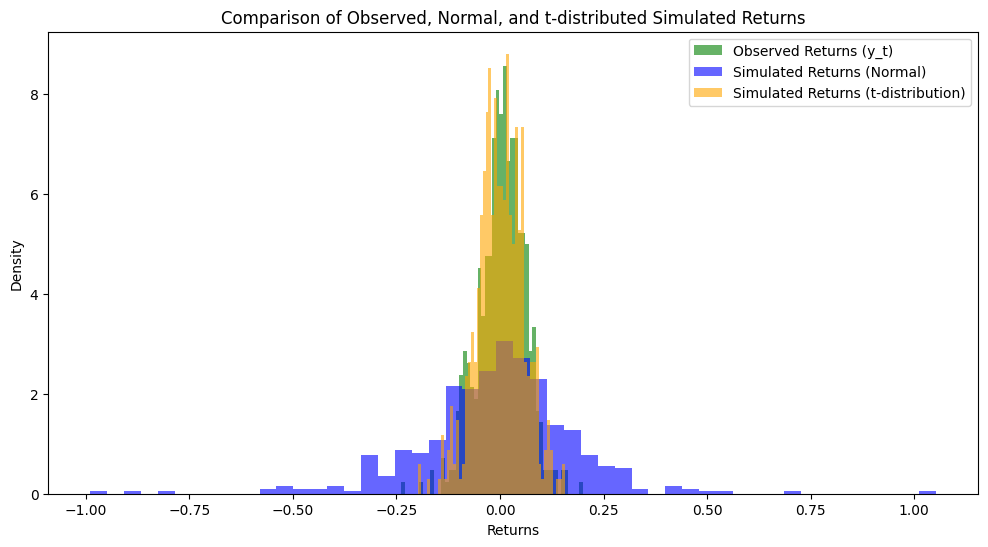

In [ ]:
# 正規分布仮定でのシミュレーション
simulated_y_normal, _ = sv_model_simulation(alpha_mean, beta_mean, tau2_mean, np.log(y_t[0]), len(y_t))

# t分布仮定でのシミュレーション
simulated_y_t, _ = sv_model_simulation(alpha_mean_t, beta_mean_t, tau2_mean_t, np.log(y_t[0]), len(y_t))

# 分布の比較プロット
plt.figure(figsize=(12, 6))

# 実データのヒストグラム
plt.hist(y_t, bins=50, density=True, alpha=0.6, label="Observed Returns (y_t)", color="green")

# 正規分布仮定のヒストグラム
plt.hist(simulated_y_normal, bins=50, density=True, alpha=0.6, label="Simulated Returns (Normal)", color="blue")

# t分布仮定のヒストグラム
plt.hist(simulated_y_t, bins=50, density=True, alpha=0.6, label="Simulated Returns (t-distribution)", color="orange")

# プロット設定
plt.title("Comparison of Observed, Normal, and t-distributed Simulated Returns")
plt.xlabel("Returns")
plt.ylabel("Density")
plt.legend()
plt.show()


In [ ]:
from scipy.stats import ks_2samp
from scipy.stats import wasserstein_distance

# --- Kolmogorov-Smirnov検定 --- #
ks_stat_normal, p_value_normal = ks_2samp(y_t, simulated_y_normal)
ks_stat_t, p_value_t = ks_2samp(y_t, simulated_y_t)

print(f"KS Test (Normal Distribution): Statistic = {ks_stat_normal:.4f}, p-value = {p_value_normal:.4f}")
print(f"KS Test (t-Distribution): Statistic = {ks_stat_t:.4f}, p-value = {p_value_t:.4f}")

# --- Wasserstein距離 --- #
wasserstein_normal = wasserstein_distance(y_t, simulated_y_normal)
wasserstein_t = wasserstein_distance(y_t, simulated_y_t)

print(f"Wasserstein Distance (Normal Distribution): {wasserstein_normal:.4f}")
print(f"Wasserstein Distance (t-Distribution): {wasserstein_t:.4f}")


KS Test (Normal Distribution): Statistic = 0.2313, p-value = 0.0000
KS Test (t-Distribution): Statistic = 0.0792, p-value = 0.0987
Wasserstein Distance (Normal Distribution): 0.0910
Wasserstein Distance (t-Distribution): 0.0057
